# Census Income - Análise 

In [153]:
## importando os pacotes e setando algumas configurações
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
get_ipython().run_line_magic('matplotlib', 'inline')

### Funções

In [154]:

def binarizeColumn(col, value, new_name):
    ## função usada para transformar colunas categóricas em binárias
    df[col] = np.where(df[col] == value, 1, 0)
    df.rename(columns = {col:new_name}, inplace = True)
    print(df[new_name].value_counts())
    
def checkMeanSTD(col, original_data):
    ## função para avaliar a média e desvio padrão de cada valor dentro de uma coluna
    df_col = original_data[col]
    df_col = pd.DataFrame(df_col.value_counts())
    df_col

    df_col = df_col.index
    for i in df_col:
        j = original_data[original_data[col] == i ]
        print('-------------------------------------')
        print(i)
        print(j['less_than_50k?'].describe()[['count', 'mean','std']])
    plt.figure(figsize=[24,8])
    sns.countplot(original_data[col], hue=original_data['less_than_50k?']);
    
def highlightHighlyCorrel(val):
    ## função para pintar os valores altamente correlacionados da função pd.corr()
    color = 'yellow' if val > 0.5 or val < -0.5 else ''
    return 'background-color: {}'.format(color)
                                 
def columnsDescribe(col, data):
    ## função para criar o describe de cada valor dentro da coluna
    values = data[col].unique()
    for value in values:
        i = pd.DataFrame(data[data[col] == value])
        print(value)
        print(i.describe())
        
def pivotTablePct(col1, col2, data):
    """função para criar uma tabela de frequência dos valores dentro da coluna 
    e avaliar a porcentagem em comparação com outra coluna""" 
    table = pd.crosstab(data[col1], data[col2])
    table['total'] = table.iloc[:,0] + table.iloc[:,1]
    table.iloc[:,0]  = table.iloc[:,0] / table['total'] * 100
    table.iloc[:,1] = table.iloc[:,1] / table['total'] * 100
    i = round(table,2)
    i = i.sort_values(by='total', ascending=False)
    return i

### Carregando os dados e alterando os nomes das colunas.

In [155]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(path, skiprows=2, index_col=False, header=None)

old = df

print(df.shape)
df.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income',
]
df.head()

(32559, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
2,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


## Analíse Inicial:
- #### Colunas que poderiam ser binárias são categóricas: usar np.where() para binarizar essas colunas.  
- #### Valores inexistentes são descritos como ' ?': usar a função pd.DataFrame.replace(), para alterar o '?' para np.NaN.    
- #### Maior parte das colunas são categóricas: usar a função pd.get_dummies() para criar colunas one-hot encoding.
- #### Variáveis podem ser altamente correlacionadas, como por ex. education e education_num: fazer um tabela com o valor da correlação e excluir as colunas que apresentam alta correlação.

### Descrição das Colunas:
- age, education_num, capital_gain, capital_loss e hour_per_week:  
    Variáveis numéricas contínuas
- fnlwgt:  
    Variável numérica, [explicação fnlwgt](https://cseweb.ucsd.edu//classes/sp15/cse190-c/reports/sp15/048.pdf): essa coluna é o número de pessoas que cada entrada representa.  
    **Provavelmente seja melhor desconsiderar essa coluna.**
- sex, native_country e income:
    São variável categóricas que podem ser binarizadas.  
    sex e native_country possuem apenas dois valores.   
    native_country possui diversos valores mas quase 90% das entradas tem o mesmo valor `United-States`
- race:  
  Essa é a variável mais interessante, porque, embora ela tenha diversos valores ela pode ser binarizada.  
  Existe uma distinção muito grande entre alguns grupos.  
  White e Asian-Pac-Islander apresentam média e desvio padrão semelheantes, enquanto os outros grupo também apresentam valores semelhantes entre si.
- workclass, education, marital_status, occupation, relationship:  
    Diferentemente da coluna race, são variáveis que apresentam média e desvio padrão distantes entre si.  
    Portanto é melhor rodar a função get_dummies or a one-hot enconding, eu prefiro a get_dummies porque ela nomeia as colunas criadas.

In [156]:
## Dropando coluna fnlwgt, ela é o número de pessoas que cada entrada representa.
df.drop('fnlwgt', axis=1, inplace=True)

## Analíse Exploratória dos Dados

In [157]:
## criando um dataframe para as colunas numéricas
df_num = [col_name for col_name in df.columns if df[col_name].dtype != 'object']
df_num = df[df_num]
df_num.head()

,age,education_num,capital_gain,capital_loss,hours_per_week
0,38,9,0,0,40
1,53,7,0,0,40
2,28,13,0,0,40
3,37,14,0,0,40
4,49,5,0,0,16


In [158]:
## analisando as métricas das coluna numéricas
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,32559.000000,32559.000000,32559.000000,32559.000000,32559.000000
mean,38.581283,10.080500,1077.648269,87.309193,40.438312
std,13.640705,2.572698,7385.514002,402.972014,12.346871
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


### Analíse de Outliers
- **Um modelo é uma versão simplificada da realidade.**  
    Se o modelo nunca viu um outlier, ele não reconhecerá quando um outlier acontecer no futuro
- Continuarei a analíse de outliers após transformar todas as colunas em numéricas.

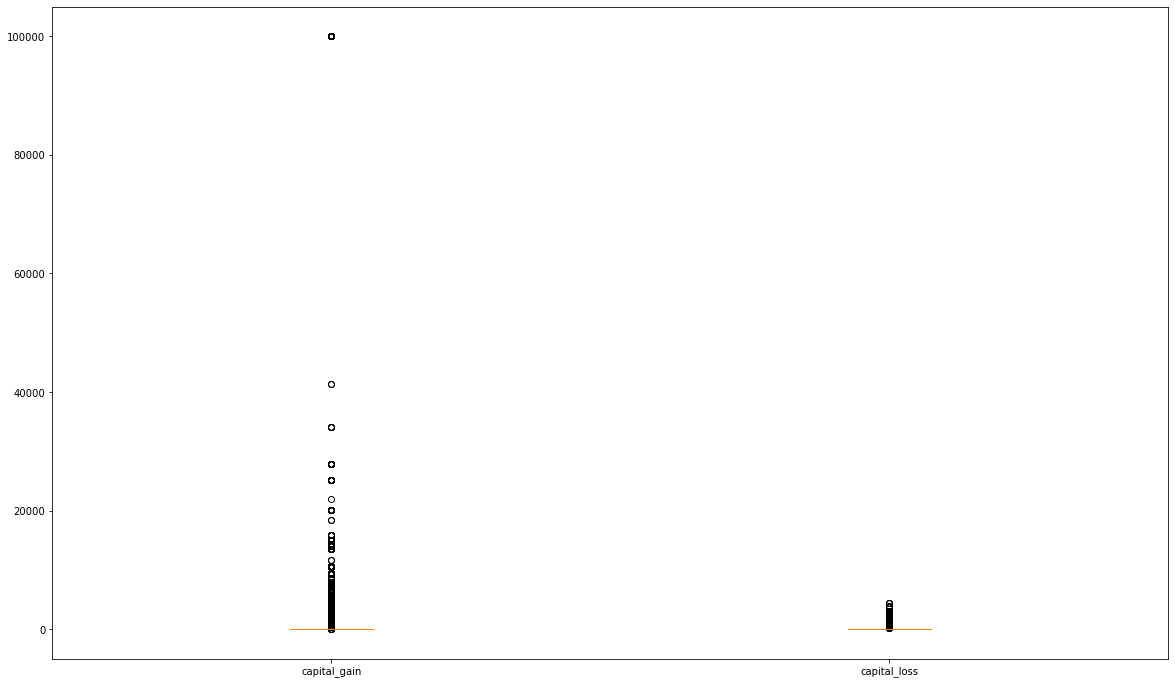

In [159]:
## cria um boxplot das colunas `capital_gain` e `capital_loss`
plt.figure(figsize=[20,12])
plt.boxplot(df_num[['capital_gain','capital_loss']]);
plt.xticks([1, 2], ['capital_gain','capital_loss']);

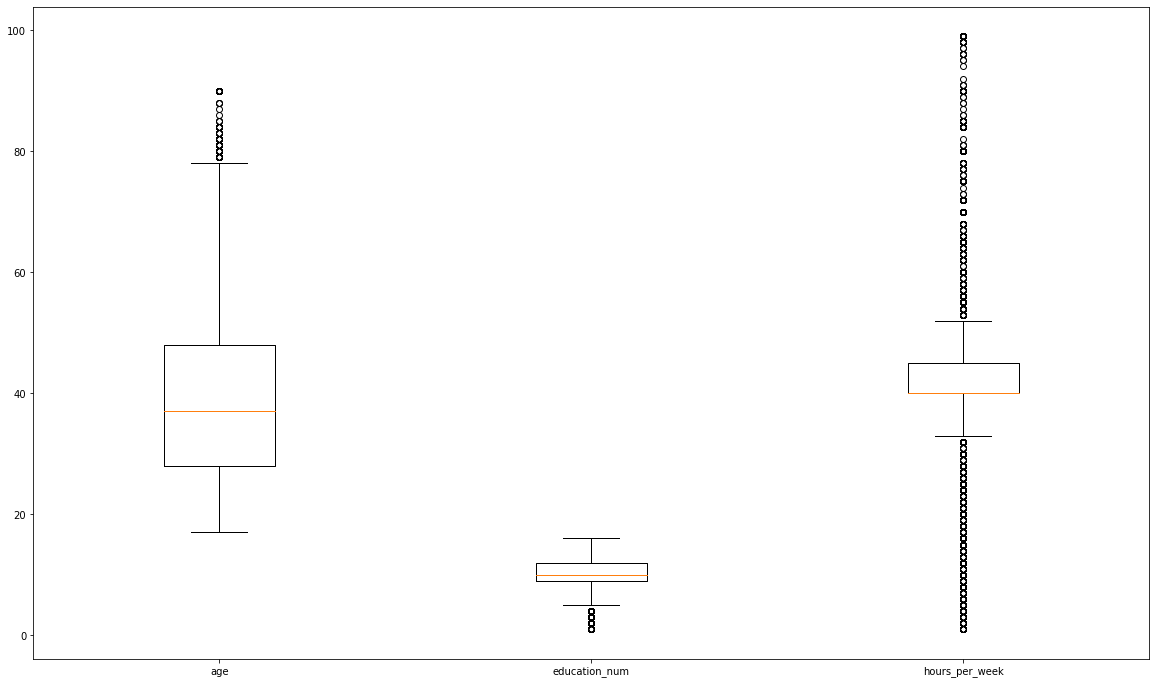

In [160]:
## cria um boxplot das colunas `age`, `education_num` e `hours_per_week`
plt.figure(figsize=[20,12])
plt.boxplot(df_num[['age','education_num','hours_per_week']]);
plt.xticks([1, 2, 3], ['age','education_num','hours_per_week']);

### Tratando os valores inexistentes.
- valores inexistentes são representados com um '?'  
    portanto é necessário transforma-los em NaN e tratar esses dados.
- Esses casos não se tratam necessariamente de desempregados, uma vez que a média de horas trabalhadas por semana é de aproximadamente 32 horas.

In [161]:
## avaliação dos casos que tem valores inexistentes
df[df['workclass'] == ' ?'].describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000
mean,40.960240,9.260349,606.795752,60.760349,31.919390
std,20.334587,2.601986,5147.323872,354.685264,14.909903
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,21.000000,9.000000,0.000000,0.000000,20.000000
50%,35.000000,9.000000,0.000000,0.000000,36.000000
75%,61.000000,10.000000,0.000000,0.000000,40.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [162]:
## vizualização de uma das linhas com " ?"
df[77:78]

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
77,31,Local-gov,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<=50K


In [163]:
## altera os valores de " ?" para np.NaN
df.replace(" ?", np.NaN, inplace=True)
print(df.isnull().sum())
df[77:78]

age                  0
workclass         1836
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
77,31,Local-gov,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<=50K


In [164]:
## exclui as linhas com valores inexistentes
df.dropna(inplace=True)
df[77:78]

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
84,49,Local-gov,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


## Verificando os dados das colunas categóricas

### Transformando algumas das variáveis categoricas em variáveis booleanas

- Coluna `income`

In [165]:
## avalia a contagem de vezes que cada valor aparece na coluna
df['income'].value_counts()

 <=50K    22652
 >50K      7508
Name: income, dtype: int64

In [166]:
## função para binarizar a coluna
binarizeColumn('income', ' <=50K',  'less_than_50k?')

1    22652
0     7508
Name: less_than_50k?, dtype: int64


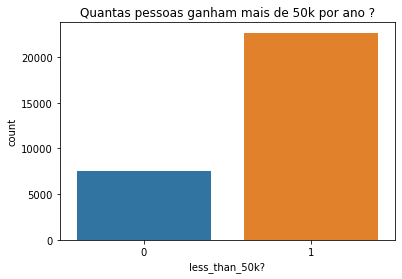

In [167]:
## plota gráfico após binarização
plt.title('Quantas pessoas ganham mais de 50k por ano ?')
sns.countplot(x='less_than_50k?', data=df);

- #### Coluna `sex`

In [168]:
df['sex'].value_counts()

 Male      20378
 Female     9782
Name: sex, dtype: int64

In [169]:
binarizeColumn('sex', ' Male',  'Male?')

1    20378
0     9782
Name: Male?, dtype: int64


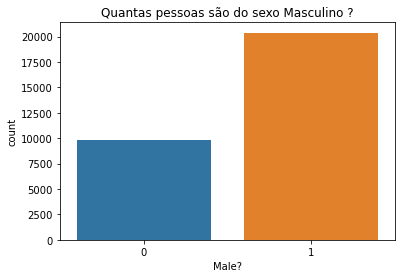

In [170]:
plt.title('Quantas pessoas são do sexo Masculino ?')
sns.countplot(x='Male?', data=df);

- #### Coluna `native_country`

In [171]:
## avalia a contagem de vezes que cada valor aparece na coluna e mostra os dez que mais aparecem
df['native_country'].value_counts()[0:10]

 United-States    27502
 Mexico             610
 Philippines        188
 Germany            128
 Puerto-Rico        109
 Canada             107
 India              100
 El-Salvador        100
 Cuba                92
 England             86
Name: native_country, dtype: int64

In [172]:
binarizeColumn('native_country', ' United-States',  'US_native?')

1    27502
0     2658
Name: US_native?, dtype: int64


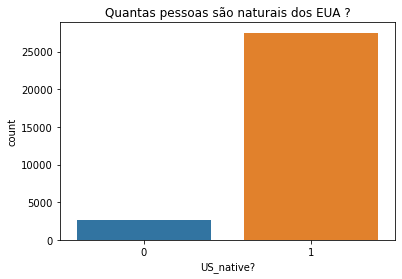

In [173]:
plt.title('Quantas pessoas são naturais dos EUA ?')
sns.countplot(x='US_native?', data=df);

- #### Coluna `race`
- Essa coluna é um caso interessante:
    Embora ela tenha diversos valores distintos, claramente existe uma semelhança entra `White` e `Asian-Pac-Islander` e entre os demais valores.  
    Essa semelhança existe tanto na média, como no desvio padrão.  
- portanto irei binarizar essa coluna.

-------------------------------------
 White
count    25931.000000
mean         0.736262
std          0.440668
Name: less_than_50k?, dtype: float64
-------------------------------------
 Black
count    2817.000000
mean        0.870075
std         0.336281
Name: less_than_50k?, dtype: float64
-------------------------------------
 Asian-Pac-Islander
count    895.000000
mean       0.722905
std        0.447814
Name: less_than_50k?, dtype: float64
-------------------------------------
 Amer-Indian-Eskimo
count    286.000000
mean       0.881119
std        0.324216
Name: less_than_50k?, dtype: float64
-------------------------------------
 Other
count    231.000000
mean       0.909091
std        0.288104
Name: less_than_50k?, dtype: float64
None


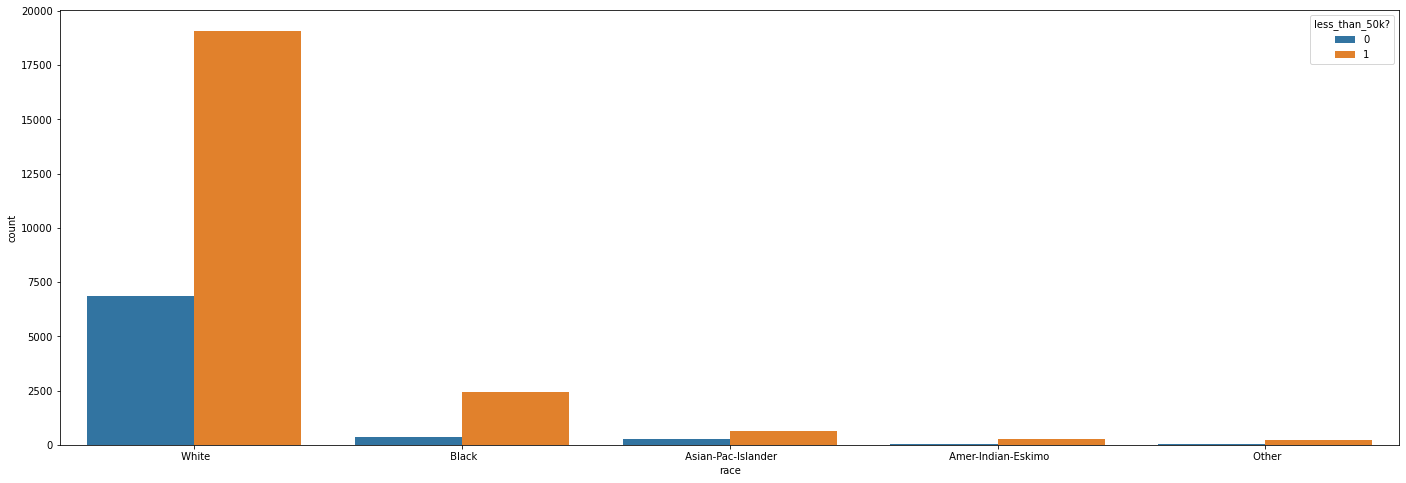

In [174]:
## avalia a média e o desvio padrão de cada valor da coluna
print(checkMeanSTD('race', df))

In [175]:
df['race'].value_counts()

 White                 25931
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

In [176]:
## binariza a coluna utilizando dois dos valores como 1
df['race'] = np.where( np.logical_or( (df['race'] == ' White'),(df['race'] == ' Asian-Pac-Islander')), 1, 0)
df.rename(columns = {'race':'White_or_Asian?'}, inplace = True)
df['White_or_Asian?'].value_counts()

1    26826
0     3334
Name: White_or_Asian?, dtype: int64

---
### Vizualizando o dataframe após a binarização

In [177]:
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?
0,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,1,1,0,0,40,1,1
1,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,0,1,0,0,40,1,1
2,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,0,0,0,0,40,0,1
3,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,1,0,0,0,40,1,1
4,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,0,0,0,0,16,0,1


---
### Vizualizando as correlações das variáveis numéricas

In [178]:
## rodando novamente porque foram adicionadas novas colunas numericas
df_num = [col_name for col_name in df.columns if df[col_name].dtype != 'object']
df_num = df[df_num]
df_num

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?
0,38,9,1,1,0,0,40,1,1
1,53,7,0,1,0,0,40,1,1
2,28,13,0,0,0,0,40,0,1
3,37,14,1,0,0,0,40,1,1
4,49,5,0,0,0,0,16,0,1
...,...,...,...,...,...,...,...,...,...
32554,27,12,1,0,0,0,38,1,1
32555,40,9,1,1,0,0,40,1,0
32556,58,9,1,0,0,0,40,1,1
32557,22,9,1,1,0,0,20,1,1


In [179]:
## checando correlação das variáveis numéricas
df.corr().style.applymap(highlightHighlyCorrel)

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?
age,1.000000,0.043494,0.025984,0.081974,0.080159,0.060173,0.101677,0.016250,-0.242022
education_num,0.043494,1.000000,0.091802,0.006105,0.124421,0.079666,0.152632,0.127190,-0.335347
White_or_Asian?,0.025984,0.091802,1.000000,0.115573,0.021464,0.029789,0.059088,0.010136,-0.100009
Male?,0.081974,0.006105,0.115573,1.000000,0.048815,0.047022,0.231348,-0.003020,-0.216731
capital_gain,0.080159,0.124421,0.021464,0.048815,1.000000,-0.032229,0.080428,0.012375,-0.221199
capital_loss,0.060173,0.079666,0.029789,0.047022,-0.032229,1.000000,0.052404,0.015124,-0.150047
hours_per_week,0.101677,0.152632,0.059088,0.231348,0.080428,0.052404,1.000000,0.010699,-0.229457
US_native?,0.016250,0.127190,0.010136,-0.003020,0.012375,0.015124,0.010699,1.000000,-0.040217
less_than_50k?,-0.242022,-0.335347,-0.100009,-0.216731,-0.221199,-0.150047,-0.229457,-0.040217,1.000000


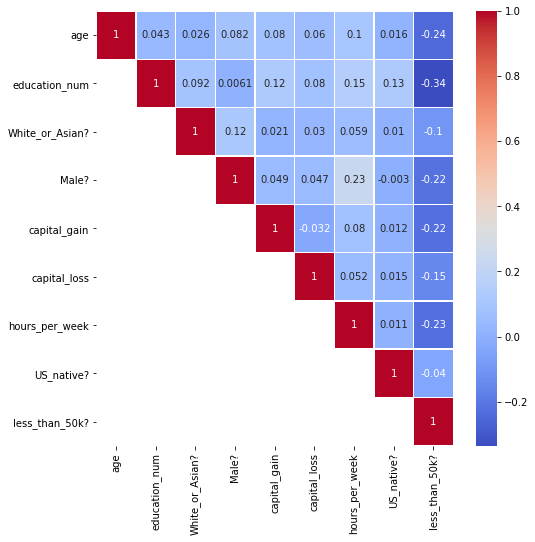

In [180]:
## outra forma de vizualizar as correlações
fig, ax = plt.subplots(figsize=(8,8))
correl_total = df_num.corr()
superior = correl_total.where(np.triu(np.ones(correl_total.shape), 
                                      k = 0).astype(np.bool))
sns.heatmap(superior, cmap = "coolwarm", annot=True, linewidths=.4);

---
### Tirando as Médias de `income` das Variaveis categóricas antes de rodar a função get_dummies()

In [181]:
## cria uma datafram com as colunas categóricas
df_cat = [col_name for col_name in df.columns if df[col_name].dtype == 'object']
df_cat = df[df_cat]
df_cat

,workclass,education,marital_status,occupation,relationship
0,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family
1,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband
2,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife
3,Private,Masters,Married-civ-spouse,Exec-managerial,Wife
4,Private,9th,Married-spouse-absent,Other-service,Not-in-family
...,...,...,...,...,...
32554,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife
32555,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband
32556,Private,HS-grad,Widowed,Adm-clerical,Unmarried
32557,Private,HS-grad,Never-married,Adm-clerical,Own-child


#### `workclass`

In [182]:
## cria uma tabela cruzada entre a coluna categórica e a coluna de income
## os valores são a porcentagem de casos que aquele valor da coluna categórica ganha ou não mais de 50k por ano
pivotTablePct('workclass', 'less_than_50k?', df)

less_than_50k?,0,1,total
workclass,,,
Private,21.88,78.12,22286
Self-emp-not-inc,28.58,71.42,2498
Local-gov,29.46,70.54,2067
State-gov,26.92,73.08,1278
Self-emp-inc,55.87,44.13,1074
Federal-gov,38.71,61.29,943
Without-pay,0.00,100.00,14


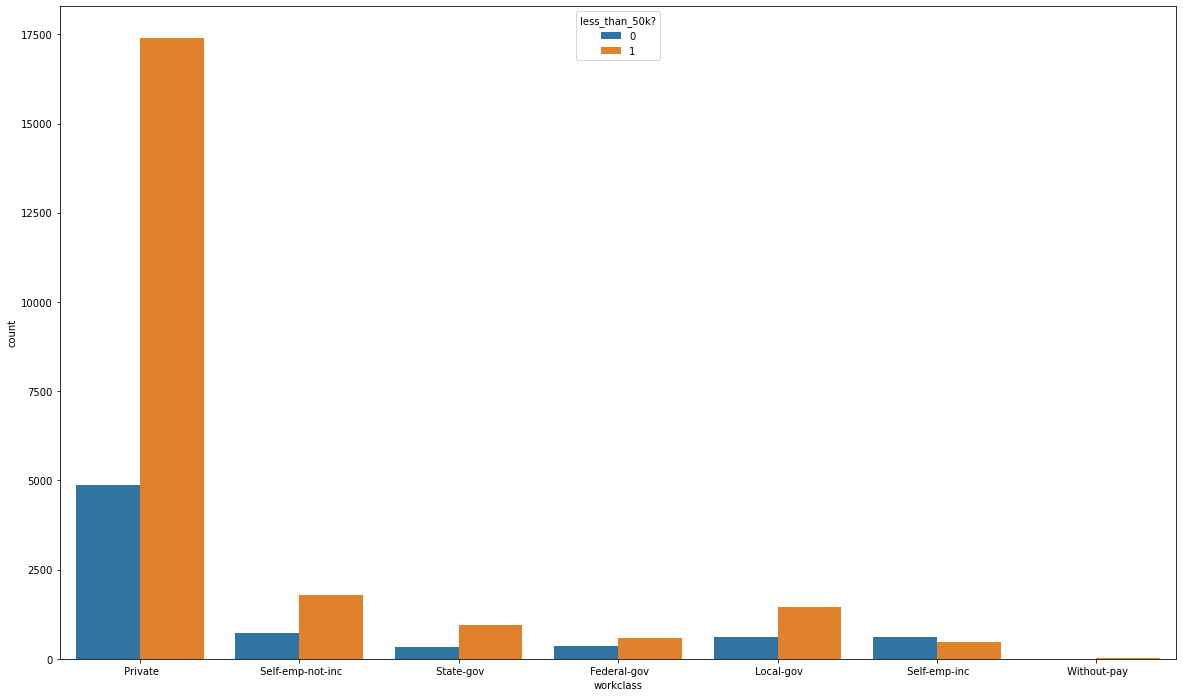

In [183]:
## plota a distribução a tabela acima
plt.figure(figsize=[20,12])
sns.countplot(df['workclass'], hue=df['less_than_50k?']);

#### `marital_status`

In [184]:
pivotTablePct('marital_status', 'less_than_50k?', df)

less_than_50k?,0,1,total
marital_status,,,
Married-civ-spouse,45.50,54.50,14064
Never-married,4.83,95.17,9725
Divorced,10.73,89.27,4214
Separated,7.03,92.97,939
Widowed,9.67,90.33,827
Married-spouse-absent,8.38,91.62,370
Married-AF-spouse,47.62,52.38,21


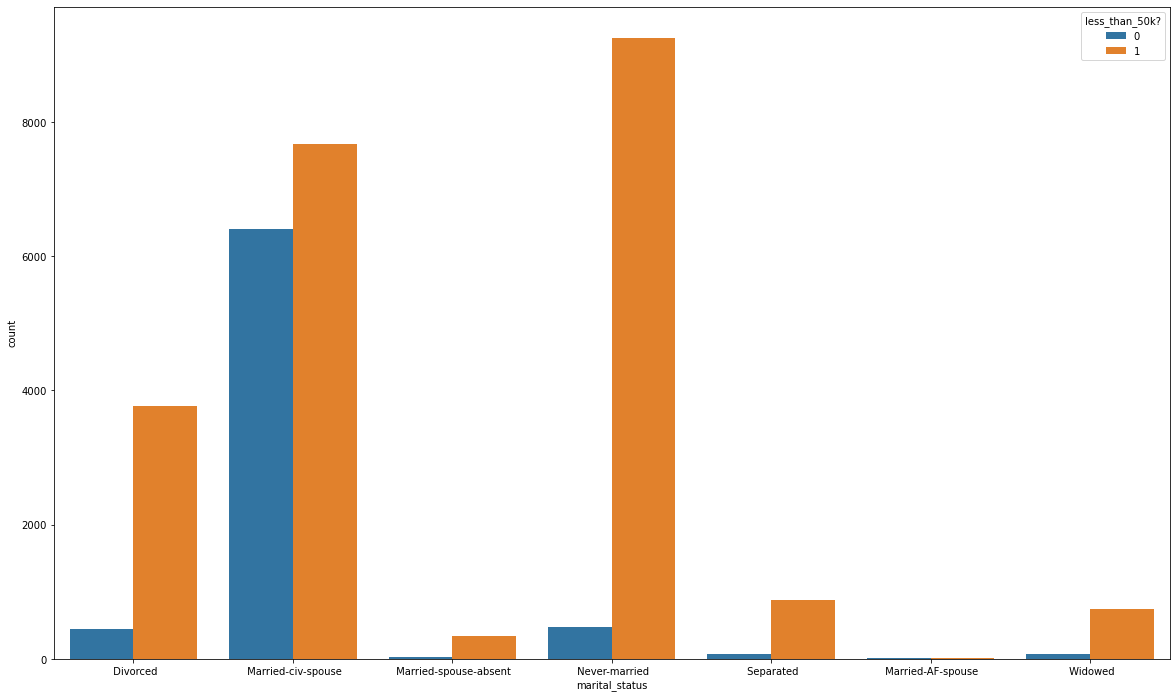

In [185]:
plt.figure(figsize=[20,12])
sns.countplot(df['marital_status'], hue=df['less_than_50k?']);

#### `occupation`

In [186]:
pivotTablePct('occupation', 'less_than_50k?', df)

less_than_50k?,0,1,total
occupation,,,
Prof-specialty,44.85,55.15,4038
Craft-repair,22.53,77.47,4030
Exec-managerial,48.53,51.47,3991
Adm-clerical,13.39,86.61,3720
Sales,27.06,72.94,3584
Other-service,4.11,95.89,3212
Machine-op-inspct,12.46,87.54,1966
Transport-moving,20.29,79.71,1572
Handlers-cleaners,6.15,93.85,1350


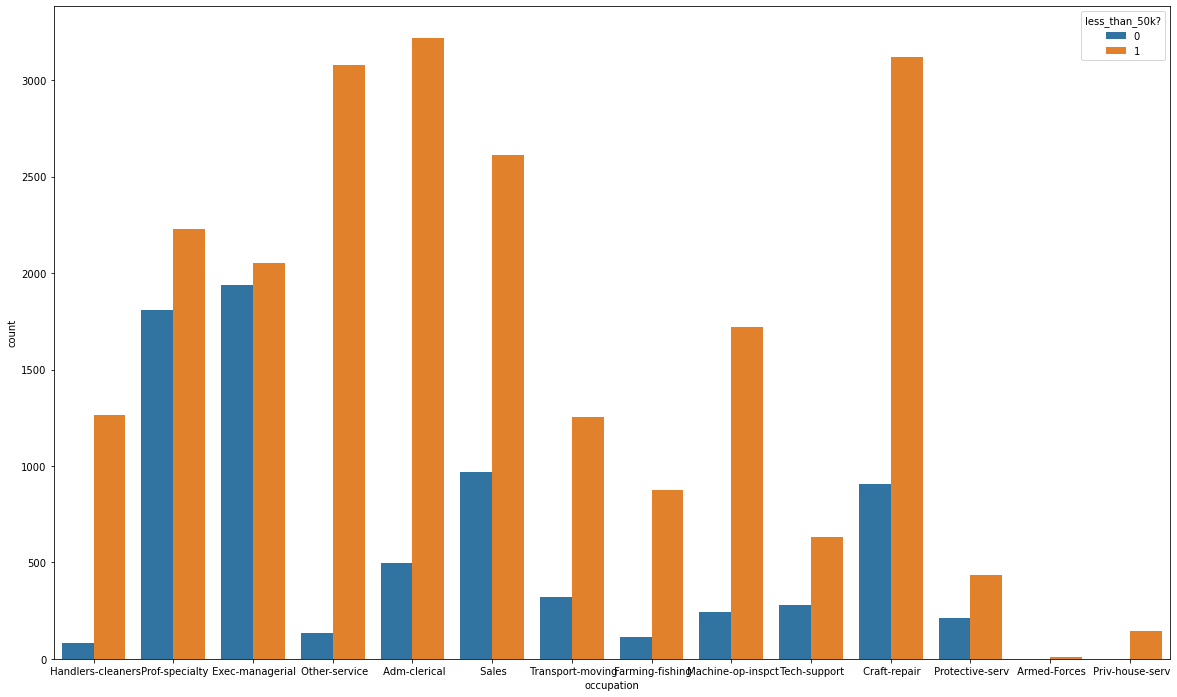

In [187]:
plt.figure(figsize=[20,12])
sns.countplot(df['occupation'], hue=df['less_than_50k?']);

#### `relationship`

In [188]:
pivotTablePct('relationship', 'less_than_50k?', df)

less_than_50k?,0,1,total
relationship,,,
Husband,45.57,54.43,12462
Not-in-family,10.65,89.35,7725
Own-child,1.43,98.57,4466
Unmarried,6.63,93.37,3212
Wife,49.36,50.64,1406
Other-relative,3.94,96.06,889


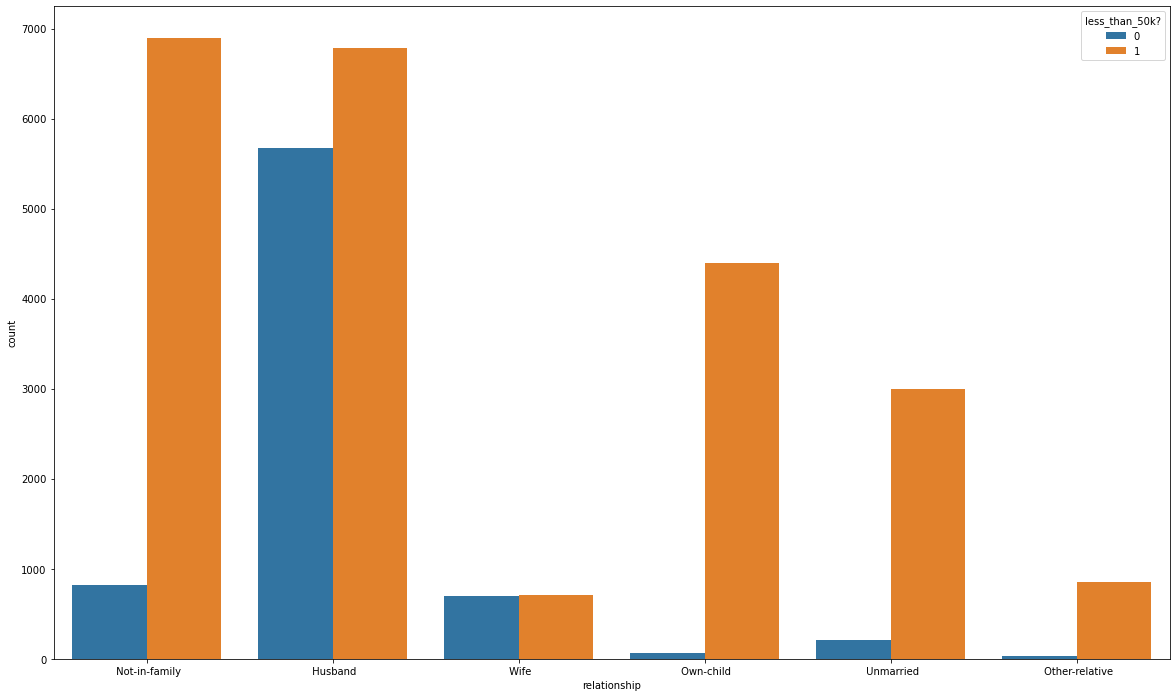

In [189]:
plt.figure(figsize=[20,12])
sns.countplot(df['relationship'], hue=df['less_than_50k?']);

#### `education`
- Quanto a Coluna Education, temos a coluna education_num, que apresenta praticamente a mesma informação.
    - A coluna Education mostra o nivel educacional maximo alcançado por aquela pessoa, 
    - Enqunto a coluna education_num mostra o tempo que aquela pessoa passou na educação formal.
- Nesse caso, acredito que seja possivel, simplesmente dropar a coluna education, ou então utilizando o k-means para diminuir ainda mais a quantidade de categorias dentro dessa variavel.

In [190]:
pivotTablePct('education', 'less_than_50k?', df)

less_than_50k?,0,1,total
education,,,
HS-grad,16.43,83.57,9840
Some-college,20.01,79.99,6678
Bachelors,42.17,57.83,5042
Masters,56.42,43.58,1627
Assoc-voc,26.32,73.68,1307
11th,5.63,94.37,1048
Assoc-acdm,25.40,74.60,1008
10th,7.20,92.80,820
7th-8th,6.28,93.72,557


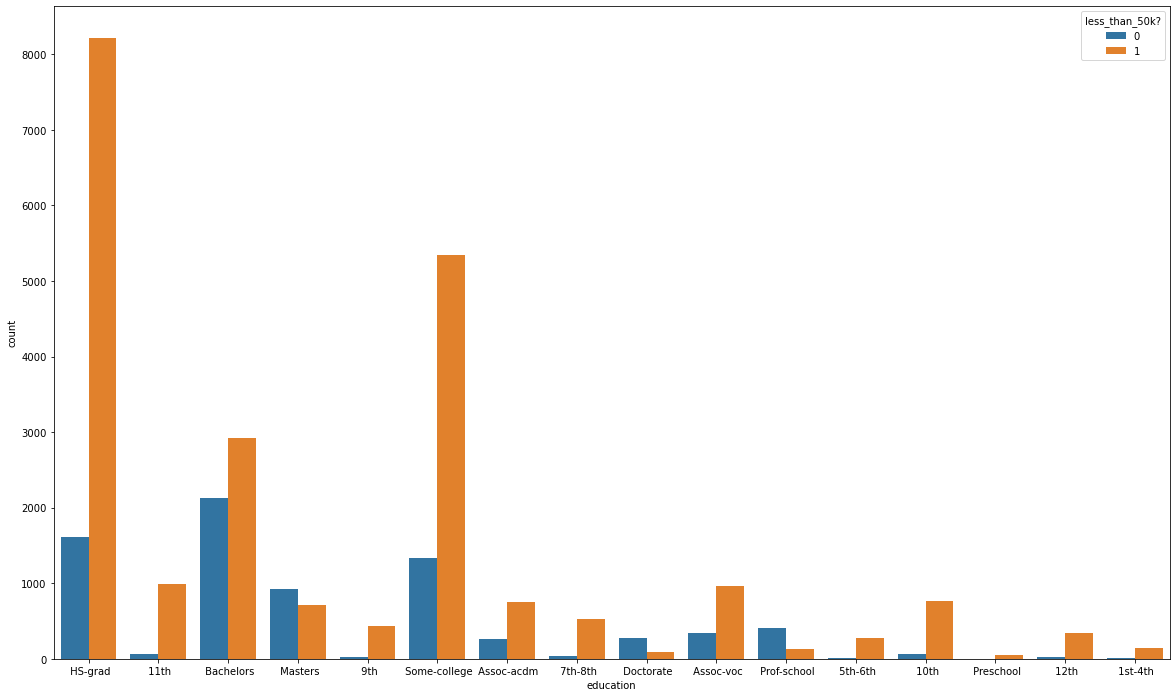

In [191]:
plt.figure(figsize=[20,12])
sns.countplot(df['education'], hue=df['less_than_50k?']);

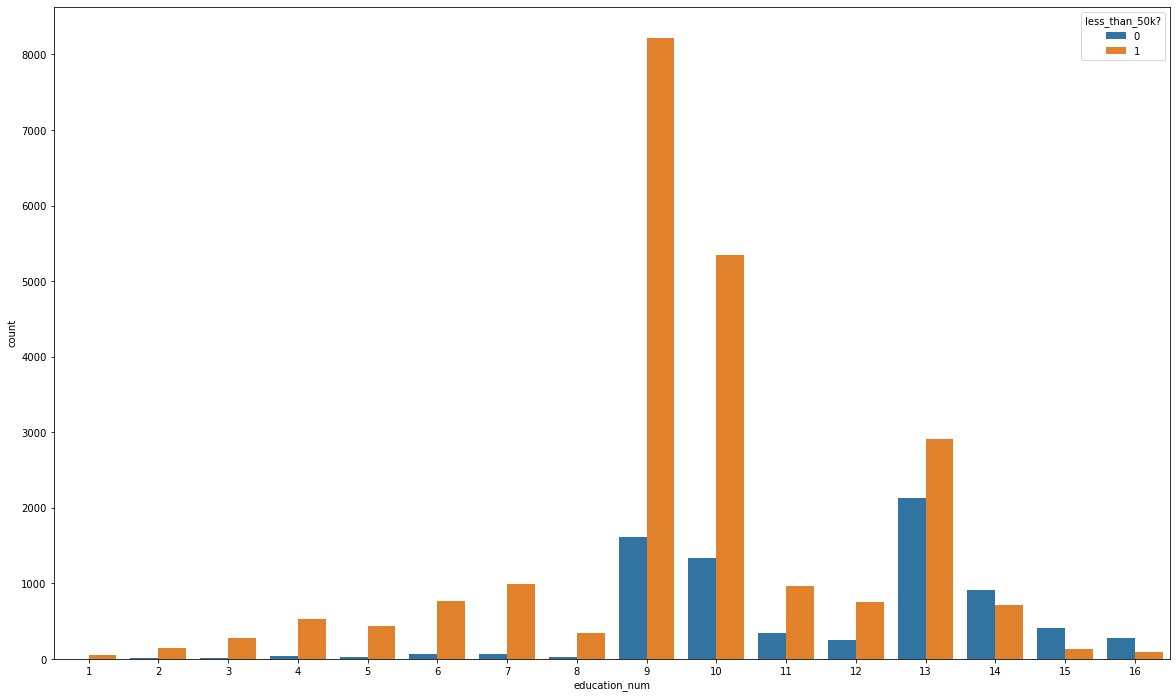

In [192]:
plt.figure(figsize=[20,12])
sns.countplot(df['education_num'], hue=df['less_than_50k?']);

---
### Transformando as colunas categóricas
- workclass, education, marital_status, occupation, relationship:  
    Diferentemente da coluna race, são variáveis que apresentam média e desvio padrão distantes entre si.  
    Portanto é melhor rodar a função pd.get_dummies ou a sklearn.OneHotEncoder, eu prefiro a get_dummies porque ela nomeia as colunas criadas.

-------------------------------------
 Husband
count    12462.000000
mean         0.544295
std          0.498054
Name: less_than_50k?, dtype: float64
-------------------------------------
 Not-in-family
count    7725.000000
mean        0.893463
std         0.308544
Name: less_than_50k?, dtype: float64
-------------------------------------
 Own-child
count    4466.000000
mean        0.985670
std         0.118863
Name: less_than_50k?, dtype: float64
-------------------------------------
 Unmarried
count    3212.000000
mean        0.933686
std         0.248869
Name: less_than_50k?, dtype: float64
-------------------------------------
 Wife
count    1406.000000
mean        0.506401
std         0.500137
Name: less_than_50k?, dtype: float64
-------------------------------------
 Other-relative
count    889.000000
mean       0.960630
std        0.194583
Name: less_than_50k?, dtype: float64


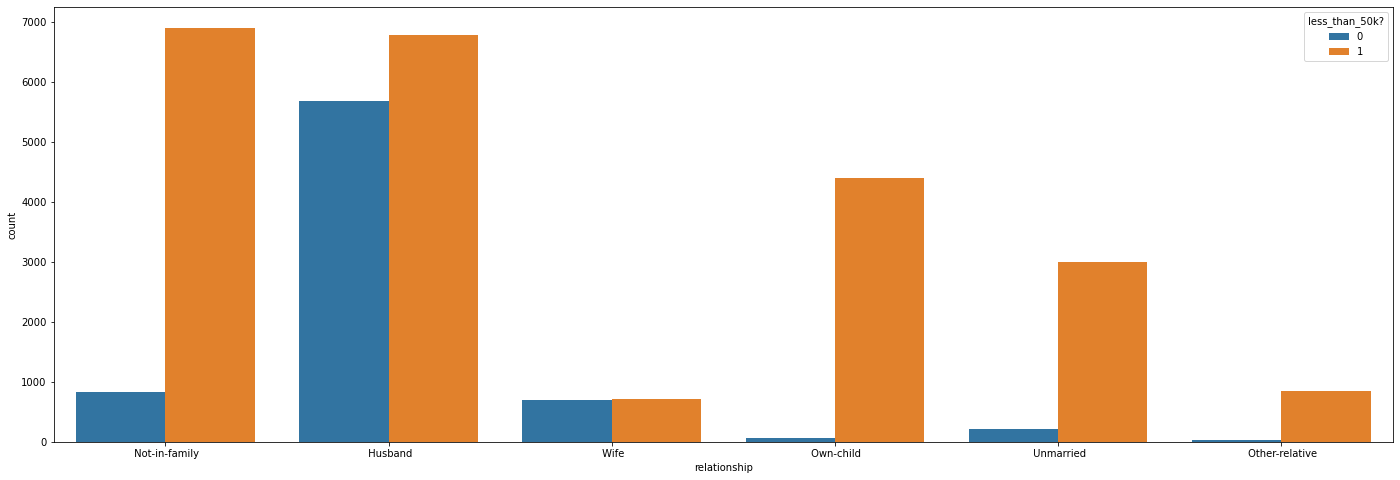

In [193]:
## exemplo do que foi descrito na celula markdown acima
checkMeanSTD('relationship', df)

In [194]:
## cria um datafram com as colunas onehot usando a função pd.get_dummies()
object_cols = df_cat.columns
object_df = df[object_cols]
object_df.drop('education', axis = 1, inplace = True)
df_getdummies = pd.get_dummies(object_df)
df_getdummies

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
32555,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
32556,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
32557,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Juntando as colunas novas (get_dummies) com as colunas numéricas

In [195]:
## Agrupa o dataframe df_num e dataframe onehot 
df = df_num.join(df_getdummies)
df.describe()

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
count,30160.000000,30160.000000,30160.000000,30160.000000,30160.00000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000
mean,38.437500,10.121121,0.889456,0.675663,1092.00819,88.378349,40.932195,0.911870,0.751061,0.031267,0.068534,0.738926,0.035610,0.082825,0.042374,0.000464,0.139721,0.000696,0.466313,0.012268,0.322447,0.031134,0.027420,0.123342,0.000298,0.133621,0.132328,0.032792,0.044761,0.065186,0.106499,0.004741,0.133886,0.021353,0.118833,0.030239,0.052122,0.413196,0.256134,0.029476,0.148077,0.106499,0.046618
std,13.134931,2.549972,0.313572,0.468134,7406.58678,404.311135,11.979301,0.283489,0.432406,0.174040,0.252665,0.439228,0.185319,0.275622,0.201444,0.021540,0.346704,0.026378,0.498872,0.110081,0.467421,0.173683,0.163308,0.328835,0.017272,0.340250,0.338852,0.178094,0.206783,0.246857,0.308480,0.068695,0.340535,0.144560,0.323597,0.171246,0.222277,0.492416,0.436504,0.169140,0.355182,0.308480,0.210823
min,17.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,1.000000,0.000000,0.00000,0.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,1.000000,1.000000,0.00000,0.000000,40.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,13.000000,1.000000,1.000000,0.00000,0.000000,45.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,1.000000,1.000000,99999.00000,4356.000000,99.000000

In [196]:
df.shape

(30160, 43)

---
### Analíse de Correlação de todas as colunas

In [197]:
## checando correlação das variáveis numéricas
df.corr().style.applymap(highlightHighlyCorrel)

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
age,1.000000,0.043494,0.025984,0.081974,0.080159,0.060173,0.101677,0.016250,-0.242022,0.056632,0.068266,-0.210462,0.111047,0.150362,0.014811,0.015338,0.136145,-0.015617,0.308312,0.015826,-0.524014,0.013098,0.246895,-0.040936,-0.010806,0.016121,0.111307,0.039452,-0.104202,-0.014952,-0.092825,0.018904,0.060626,0.005488,-0.029308,-0.018471,0.032404,0.306699,-0.024004,-0.069310,-0.420616,0.049892,0.024581
education_num,0.043494,1.000000,0.091802,0.006105,0.124421,0.079666,0.152632,0.127190,-0.335347,0.058260,0.097403,-0.164965,0.078861,0.010494,0.101227,-0.008871,-0.007441,0.000225,0.080738,-0.040613,-0.030181,-0.051788,-0.062040,-0.002039,-0.000068,-0.154513,0.201756,-0.108773,-0.137998,-0.170409,-0.181762,-0.078425,0.427089,0.003958,0.025512,0.058585,-0.125915,0.073638,0.057295,-0.092844,-0.096867,-0.059183,0.033658
White_or_Asian?,0.025984,0.091802,1.000000,0.115573,0.021464,0.029789,0.059088,0.010136,-0.100009,-0.053926,-0.039970,-0.007324,0.051196,0.060669,-0.017703,0.002688,-0.019266,0.005297,0.124567,-0.033715,-0.068085,-0.096924,-0.019801,-0.039481,-0.006153,0.044283,0.051546,0.027507,-0.027494,-0.046978,-0.091843,-0.021846,0.049489,-0.029120,0.032739,0.016558,-0.014854,0.127899,-0.002192,-0.052344,-0.018551,-0.149088,-0.002796
Male?,0.081974,0.006105,0.115573,1.000000,0.048815,0.047022,0.231348,-0.003020,-0.216731,-0.001282,-0.043057,-0.066733,0.084978,0.107467,-0.024436,-0.001510,-0.237439,-0.013933,0.437504,-0.044394,-0.175447,-0.109883,-0.181195,-0.281190,0.011970,0.227128,0.031653,0.101721,0.093803,0.027156,-0.164452,-0.091373,-0.037715,0.065103,-0.018731,-0.018697,0.133789,0.581243,-0.172081,-0.040898,-0.102203,-0.326325,-0.318826
capital_gain,0.080159,0.124421,0.021464,0.048815,1.000000,-0.032229,0.080428,0.012375,-0.221199,-0.006299,-0.009624,-0.048189,0.096482,0.033347,-0.011612,-0.001758,-0.018438,-0.002653,0.084329,-0.006542,-0.065978,-0.012539,-0.011448,-0.030152,-0.002547,-0.023035,0.057677,-0.012413,-0.024371,-0.027388,-0.042433,-0.007459,0.086309,-0.007547,0.010741,-0.010107,-0.018803,0.079609,-0.026574,-0.020173,-0.052350,-0.028796,0.015593
capital_loss,0.060173,0.079666,0.029789,0.047022,-0.032229,1.000000,0.052404,0.015124,-0.150047,0.010377,0.014723,-0.036405,0.030953,0.020247,-0.003729,-0.004711,-0.021906,-0.005770,0.081371,-0.010589,-0.061755,-0.012005,-0.004472,-0.026325,0.005183,-0.001814,0.049146,-0.011378,-0.023643,-0.019497,-0.043980,-0.011272,0.046734,-0.003447,0.009776,0.004338,-0.003249,0.077152,-0.018350,-0.014512,-0.050841,-0.040930,0.014978
hours_per_week,0.101677,0.152632,0.059088,0.231348,0.080428,0.052404,1.000000,0.010699,-0.229457,0.005216,0.001590,-0.095685,0.126251,0.088116,-0.032995,-0.014784,0.019845,0.007285,0.223729,-0.009980,-0.212881,-0.018300,-0.091252,-0.105568,-0.000383,0.044777,0.131795,0.093128,-0.055248,-0.004964,-0.182337,-0.046872,0.047353,0.023602,-0.005175,-0.021500,0.072780,0.254770,0.007380,-0.051969,-0.263769,-0.043241,-0.060993
US_native?,0.016250,0.127190,0.010136,-0.003020,0.012375,0.0

#### Caso as variáveis altamente correlacionadas tenham que ser excluidas, rodar a célula abaixo

In [198]:
## remove as colunas que tem correlação alta com colunas anteriores
correl_total = df.corr().abs()

superior = correl_total.where(np.triu(np.ones(correl_total.shape), 
                                      k = 1).astype(np.bool))

var_remove = [variaveis for variaveis in superior.columns if any(superior[variaveis] > 0.5)]

df_lowCorrel = df.drop(df[var_remove], axis=1)

print('Shape da Base de dados tratada pré remoção das correlações: ', df.shape)
print('Shape da Base de dados tratada pós remoção das correlações: ',df_lowCorrel.shape)

Shape da Base de dados tratada pré remoção das correlações:  (30160, 43)
Shape da Base de dados tratada pós remoção das correlações:  (30160, 39)


In [199]:
df = df_lowCorrel

### Continuando a Analíse de Outliers

In [200]:
## analisando os outliers da coluna `hours_per_week`
high_effort = df[df['hours_per_week'] > 60]
# high_effort.describe()
high_effort[['Male?','workclass_ Private','education_num','White_or_Asian?','less_than_50k?']].describe()

,Male?,workclass_ Private,education_num,White_or_Asian?,less_than_50k?
count,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000
mean,0.851711,0.538023,10.537072,0.936312,0.627376
std,0.355555,0.498789,2.833394,0.244313,0.483733
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,9.000000,1.000000,0.000000
50%,1.000000,1.000000,10.000000,1.000000,1.000000
75%,1.000000,1.000000,13.000000,1.000000,1.000000
max,1.000000,1.000000,16.000000,1.000000,1.000000


- Dos casos que trabalham mais de 60 horas por semana: são em média funcionários do setor privado, onde 85% são homens, com 10 anos de educação formal em média e brancos ou asiaticos, onde apenas 38% ganham mais de 50K por ano.  
Em um grupo de 30162 pessoas é esperado que 1052 trabalhem mais de 60 horas por semana
---

In [201]:
## analisando os outliers da coluna `capital_gain`
high_income_gainers = df[df['capital_gain'] > 60000]
# high_income_gainers.describe()
high_income_gainers[['Male?','workclass_ Private','education_num','White_or_Asian?','hours_per_week']].describe()

,Male?,workclass_ Private,education_num,White_or_Asian?,hours_per_week
count,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.864865,0.527027,12.986486,0.945946,50.256757
std,0.343029,0.500964,2.504381,0.226892,12.492241
min,0.000000,0.000000,5.000000,0.000000,20.000000
25%,1.000000,0.000000,12.500000,1.000000,40.000000
50%,1.000000,1.000000,13.500000,1.000000,50.000000
75%,1.000000,1.000000,15.000000,1.000000,60.000000
max,1.000000,1.000000,16.000000,1.000000,80.000000


-  Dos casos que aumentaram o income em mais de 60000 no ano: são em média funcionários do setor privado do sexo masculino, com 12 anos de educação formal (pos-graduados) e brancos ou asiaticos que trabalham em média 50 horas por semana.  
Em um grupo de 30162 pessoas é esperado que 148 ganhem mais de US$100.000 em um ano 

---
-  #### Os outliers que esse dataset possui são casos esperados e representam parte da população.   
   #### **Por isso acredito que nesse caso, não é indicado tratar os outliers**

## Dataset Pronto.

In [202]:
df.head()

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,38,9,1,1,0,0,40,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,53,7,0,1,0,0,40,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,28,13,0,0,0,0,40,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,37,14,1,0,0,0,40,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,5,0,0,0,0,16,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [203]:
df.describe()

,age,education_num,White_or_Asian?,Male?,capital_gain,capital_loss,hours_per_week,US_native?,less_than_50k?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ State-gov,workclass_ Without-pay,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
count,30160.000000,30160.000000,30160.000000,30160.000000,30160.00000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000,30160.000000
mean,38.437500,10.121121,0.889456,0.675663,1092.00819,88.378349,40.932195,0.911870,0.751061,0.031267,0.068534,0.738926,0.035610,0.042374,0.000464,0.139721,0.000696,0.466313,0.012268,0.031134,0.027420,0.123342,0.000298,0.133621,0.132328,0.032792,0.044761,0.065186,0.106499,0.004741,0.133886,0.021353,0.118833,0.030239,0.052122,0.029476,0.148077,0.106499,0.046618
std,13.134931,2.549972,0.313572,0.468134,7406.58678,404.311135,11.979301,0.283489,0.432406,0.174040,0.252665,0.439228,0.185319,0.201444,0.021540,0.346704,0.026378,0.498872,0.110081,0.173683,0.163308,0.328835,0.017272,0.340250,0.338852,0.178094,0.206783,0.246857,0.308480,0.068695,0.340535,0.144560,0.323597,0.171246,0.222277,0.169140,0.355182,0.308480,0.210823
min,17.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,1.000000,0.000000,0.00000,0.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,10.000000,1.000000,1.000000,0.00000,0.000000,40.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,13.000000,1.000000,1.000000,0.00000,0.000000,45.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,16.000000,1.000000,1.000000,99999.00000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Talvez exista a necessidade de fazer um scalling, por causa das variáveis capital_gain e capital_loss: nesse caso usaria a função sklearn.MinMaxScaler()

## RANDOM FOREST

In [204]:
from sklearn.model_selection import train_test_split

# Separando os dados entre treinamento e teste

# Separando os dados com as variaveis em x e o alvo em y

x = df.drop("less_than_50k?", axis = 1)
y = df["less_than_50k?"]

# Separando entre treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 1)

In [205]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', max_depth = 10, max_features = 'auto',
           min_samples_leaf = 2, min_samples_split = 5,
           n_estimators = 500, n_jobs = -1, oob_score = True)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       oob_score=True)

In [206]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [207]:
imp = pd.DataFrame({'Variaveis':x_train.columns, 'Importancia':model.feature_importances_})

print(imp.sort_values(by=['Importancia'], ascending = False).head())

                             Variaveis  Importancia
16  marital_status_ Married-civ-spouse     0.247902
4                         capital_gain     0.193502
1                        education_num     0.146673
0                                  age     0.090679
6                       hours_per_week     0.056818


- [Precision, Recall ou F1-Score](https://medium.com/@djalmajr07/precision-recall-ou-f1-score-qual-a-melhor-m%C3%A9trica-para-utilizar-em-seu-modelo-e0d87877ed55)  
- [Dealing with unbalanced data](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fhow-to-deal-with-unbalanced-data-d1d5bad79e72)  
- [Oversampling and Undersampling](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Foversampling-and-undersampling-5e2bbaf56dcf)

In [208]:
from sklearn.metrics import confusion_matrix, classification_report
print('TRAIN')
print(confusion_matrix(y_train, y_pred_train))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train, y_pred_train))
print()
print('TEST')
print(confusion_matrix(y_test, y_pred_test))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test, y_pred_test))

TRAIN
[[ 2128  1629]
 [  417 10906]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      3757
           1       0.87      0.96      0.91     11323

    accuracy                           0.86     15080
   macro avg       0.85      0.76      0.79     15080
weighted avg       0.86      0.86      0.85     15080


TEST
[[ 2036  1715]
 [  440 10889]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.82      0.54      0.65      3751
           1       0.86      0.96      0.91     11329

    accuracy                           0.86     15080
   macro avg       0.84      0.75      0.78     15080
weighted avg       0.85      0.86      0.85     15080



In [216]:
## checking which confusion matrix, I am using. 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
(tn, fp, fn, tp)

(2036, 1715, 440, 10889)

## ADRESSING UNBALANCED DATA

In [210]:
# pip install imbalanced-learn

In [211]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=1)

x_sample_train, y_sample_train = sampler.fit_resample(x_train, y_train)

In [212]:
model = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', max_depth = 10, max_features = 'auto',
           min_samples_leaf = 2, min_samples_split = 5,
           n_estimators = 500, n_jobs = -1, oob_score = True)

model.fit(x_sample_train, y_sample_train)

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       oob_score=True)

In [213]:
y_sample_pred_train = model.predict(x_sample_train)
y_sample_pred_test = model.predict(x_test)

In [214]:
from sklearn.metrics import confusion_matrix, classification_report
print('TRAIN')
print(confusion_matrix(y_sample_train, y_sample_pred_train))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_sample_train, y_sample_pred_train))
print()
print('TEST')
print(confusion_matrix(y_test, y_sample_pred_test))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test, y_sample_pred_test))

TRAIN
[[10372   951]
 [ 2381  8942]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     11323
           1       0.90      0.79      0.84     11323

    accuracy                           0.85     22646
   macro avg       0.86      0.85      0.85     22646
weighted avg       0.86      0.85      0.85     22646


TEST
[[3260  491]
 [2470 8859]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.57      0.87      0.69      3751
           1       0.95      0.78      0.86     11329

    accuracy                           0.80     15080
   macro avg       0.76      0.83      0.77     15080
weighted avg       0.85      0.80      0.81     15080



# COMPARING

In [215]:
print('TEST without SAMPLER')
print( confusion_matrix( y_test, y_pred_test ) /len( y_test ) * 100)
print()
print(classification_report(y_test, y_pred_test))
print("--------------------------------------------------------------------------------")
print('TEST with SAMPLER')
print(confusion_matrix(y_test, y_sample_pred_test) /len( y_test ) * 100)
print()
print(classification_report(y_test, y_sample_pred_test))

TEST without SAMPLER
[[13.50132626 11.37267905]
 [ 2.91777188 72.20822281]]

              precision    recall  f1-score   support

           0       0.82      0.54      0.65      3751
           1       0.86      0.96      0.91     11329

    accuracy                           0.86     15080
   macro avg       0.84      0.75      0.78     15080
weighted avg       0.85      0.86      0.85     15080

--------------------------------------------------------------------------------
TEST with SAMPLER
[[21.61803714  3.25596817]
 [16.37931034 58.74668435]]

              precision    recall  f1-score   support

           0       0.57      0.87      0.69      3751
           1       0.95      0.78      0.86     11329

    accuracy                           0.80     15080
   macro avg       0.76      0.83      0.77     15080
weighted avg       0.85      0.80      0.81     15080



### Interpretando os Resultados
Verdadeiro Positivo: pessoa que o modelo disse que ganha **menos** que 50k, e na realidade ganha **menos** que 50K  
Verdadeiro Negativo: pessoa que o modelo disse que ganha **mais** que 50k, e na realidade ganha **mais** que 50K  
Falso Positivo: pessoa que o modelo disse que ganha **menos** que 50k, mas na realidade ganha **mais** que 50K      
Falso Negativo: pessoa que o modelo disse que ganha **mais** que 50k, mas na realidade ganha **menos** que 50K  

In [217]:
print('TEST without SAMPLER')
print( confusion_matrix( y_test, y_pred_test ) /len( y_test ) * 100)
print("--------------------------------------------------------------------------------")
print('TEST with SAMPLER')
print(confusion_matrix(y_test, y_sample_pred_test) /len( y_test ) * 100)

TEST without SAMPLER
[[13.50132626 11.37267905]
 [ 2.91777188 72.20822281]]
--------------------------------------------------------------------------------
TEST with SAMPLER
[[21.61803714  3.25596817]
 [16.37931034 58.74668435]]


### Qual Modelo é Melhor ?  Depende da solução que está sendo buscada.

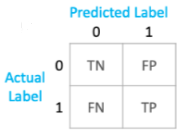

#### Suponha que um banco tenhha duas opções de linhas de crédito em um banco, uma de 100k e outra de 20k.

1. A linha de crédito de 100k somente pessoas com renda **acima** de 50k deveriam receber essa oferta.  
    Nesse caso estou buscando maximizar o Verdadeiro Negativo e minimizar o Falso Negativo.
- Verdadeiro Positivo: não recebe;   
- Verdadeiro Negativo: recebe, *BAIXO* risco de inadimplencia;
- Falso Positivo: não recebe;  
- Falso Negativo: recebe, *ALTO* risco de inadimplencia;
######  
2. Já a linha de crédito de 20k somente pessoas com renda **abaixo** de 50k deveriam receber essa oferta.   
    Nesse caso estou buscando maximizar o Verdadeiro Positivo e minimizar o Falso Positivo.
- Verdadeiro Positivo: recebe, *BAIXO* risco de inadimplencia;  
- Verdadeiro Negativo: não recebe;  
- Falso Positivo: recebe, mas essa pessoa poderia deveria ter recebido uma oferta **maior**
- Falso Negativo: não recebe;

Em ambos os casos, o modelo **DESBALANCEADO** é melhor.  
Embora o modelo **BALANCEADO** aumente a quantidade de pessoas receberão a oferta de 100k, ele tambem aumenta o risco de inadimplencia.  
Claro que fatores como juros, tempo para pagamento da divida e outros fatores devem ser levados em consideração para uma resposta mais correta.

---
### Conclusão
- Essa é a base de dados mais parecida com as bases de mundo real que ja trabalhei, foi meu primeiro trabalho de entender as colunas e trabalha-las para construir novas features.
- Primeira vez que utilizei a função smote para balancear a base de treino. a 
